In [1]:
from collections import OrderedDict
from classes import *

In [9]:
import pandas as pd
import numpy as np

l1=[1,2,3,4,5]
l2=[7,4,6,45,2]

x=pd.DataFrame([l1,l2],columns=[1,2,3,4,5])
x.to_csv()

In [2]:
wt_sq = 'MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK'

In [3]:
num_iter=1
mse_train=[]
mse_val=[]

for it in range(num_iter):
    clear_output()
    print 'ITERATION #', it
    
    timestr = time.strftime("%Y%m%d-%H%M")
    log_dir = 'tmp/'+timestr+'/'

    if not os.path.exists(log_dir):
        os.makedirs(log_dir)

    num_scales=int(it/3)+1
    block_repeats=3
    NN_name='ResNet'
    mode='gpu'
    kernel_size=3
    pool_size=3
    weight_decay=0.1
    keep_prob=0.9

    n_epoch=10
    
    reset_graph()

    f='data/amino_acid_genotypes_to_brightness.txt'
    batch_size,zero_sample_fraction = 100, 0.5

    input_data = Data(file_path=f,batch_size=batch_size,zero_sample_fraction=zero_sample_fraction, zeroing=True)
    
    nn_instance = ResNet(input_data, num_scales, block_repeats, NN_name, mode,
                     kernel_size, pool_size, weight_decay, keep_prob, n_epoch)
    
    train_mse_hist, val_mse_hist = train_NN(nn_instance, input_data, 20, log_dir)
    
    mse_train.append(train_mse_hist[-1])
    mse_val.append(val_mse_hist[-1])
    
    if it==0:
        print 'Generating data for prediction'
        
        wt_sq = 'MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK'
        unique_mutations = []
        for mut in input_data.mutant_list:
            unique_mutations.extend(mut)

        unique_mutations = [[x] for x in set(unique_mutations)]
        
        #start the list with a wild-type
        sq_test_set = [wt_sq]

        for mutant in unique_mutations:
            sq_test_set.append(make_mutant_sq(wt_sq, mutant))
            
        #creating the initial 0-filled carcas of unfolded versions of sqs, which will be further turned into binary matricies of shape 238 by 20 (aas)
        unfolded_df = OrderedDict()

        for aa in set([item[-1] for sublist in unique_mutations for item in sublist]):
            unfolded_df[aa] = np.zeros((len(sq_test_set), len(wt_sq)))

        #filling the binary matrices, corresponding to 20 different amino acids within the unfoded_df dict

        for ind,mutant in enumerate(sq_test_set):
            for pos,mut in enumerate(mutant):
                unfolded_df[mut][ind, pos] = 1.  
                
        #stacking all the amino acids into one np array
        input_df = np.stack(unfolded_df.values(),axis=1)

        #putting the channel info (amino acids) to the end
        input_df = np.swapaxes(input_df,-1,-2)
    
    print 'Deleting input data'
    del input_data
    
    print 'Restoring session for prediction'
    with tf.Session() as sess:
    
        saver = tf.train.Saver()
        saver.restore(sess, log_dir+"model.ckpt")
        predictions_test = sess.run(nn_instance.preds_val,{nn_instance.x_val_ph:input_df})
        
    if it==0:
        recording_predictions = np.zeros(shape=[len(input_df), num_iter])
        
    for i,val in enumerate(predictions_test):
        if val[0] > 3.72:
            recording_predictions[i,it]=1
            
    print 'Writing results to file'
    np.save('tmp/recorded_predictions_increasing_block_repeats.npy',recording_predictions)
    
plt.figure(figsize=[10,8])
plt.plot([int(x/3)+1 for x in range(len(mse_train))],mse_train,'ok',label='Train',ms=10)
plt.plot([int(x/3)+1 for x in range(len(mse_val))],mse_val,'ob',label='Test',ms=10)
plt.ylabel('MSE',fontsize=20)
plt.xlabel('Number of blocks',fontsize=20)
plt.legend()
plt.grid('k',lw=0.5)
plt.savefig('model_reproducibility.pdf')

ITERATION # 0


functions.py:87: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  labels=labels.reshape(-1,1)
functions.py:90: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  sample_weights=sample_weights.reshape(-1,1)
/nfs/scistore08/kondrgrp/eputints/.local/lib/python2.7/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Initializing NN
Epoch #			Train MSE		Test MSE
0			2.68			2.87
Generating data for prediction
Deleting input data
Restoring session for prediction
INFO:tensorflow:Restoring parameters from tmp/20180405-1527/model.ckpt
Writing results to file


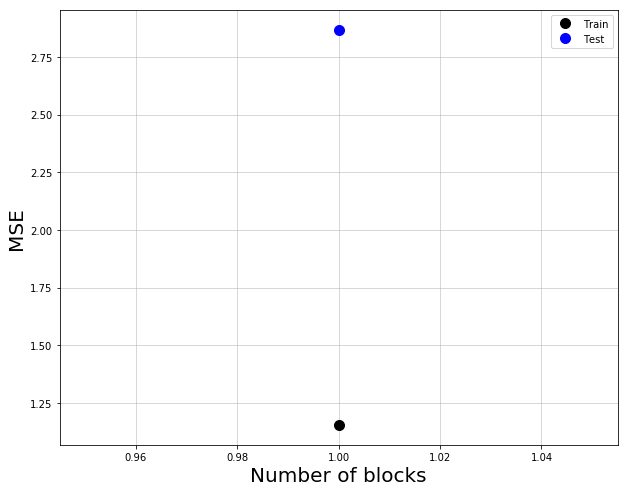

In [5]:
%matplotlib inline